<a href="https://colab.research.google.com/github/swilsonmfc/nlp/blob/master/BertQuestionAnswer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Question - Answer

![](https://garzaprotocol.com/wp-content/uploads/questions-answers.jpg)

# Setup

In [2]:
!pip install transformers

     |████████████████████████████████| 1.1MB 2.8MB/s 
     |████████████████████████████████| 890kB 18.5MB/s 
     |████████████████████████████████| 1.1MB 15.1MB/s 
     |████████████████████████████████| 3.0MB 29.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=cbe31748cad1e5f7e4d7679c8a46d82e21d13665c2d2e8cac16d5ae4187ffb1b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
!pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp36-none-any.whl size=11686 sha256=2c5505b8daf6a8004886740f38b96a632817cfde8ba27951a8b447ba51c01848
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer
from transformers import BertForQuestionAnswering

import torch
import wikipedia
import json
import textwrap

# Download Models

In [5]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Using BERT
* Tokenizes known text and word chunks (if not in vocabulary)
* Uses embeddings - those embeddings can "adapt" given word context
* Trained with special tokens:
  * [CLS] Classification
  * [SEP] Sentence 1, Sentence 2 (does sentence 2 follow sentence 1)
* For Question & Answer:
  * Sentence 1 = Question
  * Sentence 2 = Text Context
* Scoring
  * Our goal is to find the part of the text context that answers the question
  * We need to find the starting token of that text
  * We also need the ending token
  * We may want to say we don't know if the answer isn't there

## BERT

![](https://miro.medium.com/max/2348/0*m_kXt3uqZH9e7H4w.png)

## Question

![](http://www.mccormickml.com/assets/BERT/SQuAD/input_formatting.png)

## Answer - Starting Token

![](http://www.mccormickml.com/assets/BERT/SQuAD/start_token_classification.png)

## Answer - Ending Token
* Note we may need a constraint where starting token is strictly <= ending token

![](http://www.mccormickml.com/assets/BERT/SQuAD/end_token_classification.png)

# Question Answer
* Helper function that forms the question and answer into an arrangement that BERT can handle
* Condense Subwords = Rewrite subword tokens back into human readable
* Display Tokens = Show the q&a tokenized
* Display Scores = Show the softmax by token for start and ending word 

In [7]:
def q_and_a(question, answer_text, condense_subwords=False, display_tokens=False, display_scores=False):
  if len(answer_text) > 400:
    answer_text = answer_text[0:400]

  input_ids = tokenizer.encode(question, answer_text)
  tokens = tokenizer.convert_ids_to_tokens(input_ids)

  if display_tokens:
    for token, id in zip(tokens, input_ids):
        if id == tokenizer.sep_token_id:
            print('')
        print('{:<12} {:>6,}'.format(token, id))
        if id == tokenizer.sep_token_id:
            print('')
    
  sep_index = input_ids.index(tokenizer.sep_token_id)
  num_seg_a = sep_index + 1
  num_seg_b = len(input_ids) - num_seg_a

  segment_ids = [0]*num_seg_a + [1]*num_seg_b
  assert len(segment_ids) == len(input_ids)

  out = model(torch.tensor([input_ids]), # The tokens representing our input text.
              token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

  start_scores = out[0]
  end_scores   = out[1]

  answer_start = torch.argmax(start_scores)
  answer_end = torch.argmax(end_scores)

  answer = ' '.join(tokens[answer_start:answer_end+1])
  if condense_subwords:
    answer = answer.replace(' ##', '')
  print('Answer: "' + answer + '"')

  if display_scores:
    s_scores = start_scores.detach().numpy().flatten()
    e_scores = end_scores.detach().numpy().flatten()

    token_labels = []
    for (i, token) in enumerate(tokens):
        token_labels.append('{:} - {:>2}'.format(token, i))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), sharey=True)
    ax1 = sns.barplot(y=token_labels, x=s_scores, ci=None, orient='h', ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="center")
    ax1.grid(True)
    plt.title('Start Word Scores')

    ax2 = sns.barplot(y=token_labels, x=e_scores, ci=None, orient='h', ax=ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha="center")
    ax2.grid(True)
    plt.title('End Word Scores')
    plt.show()

# Scores

Answer: "a puppeteer"


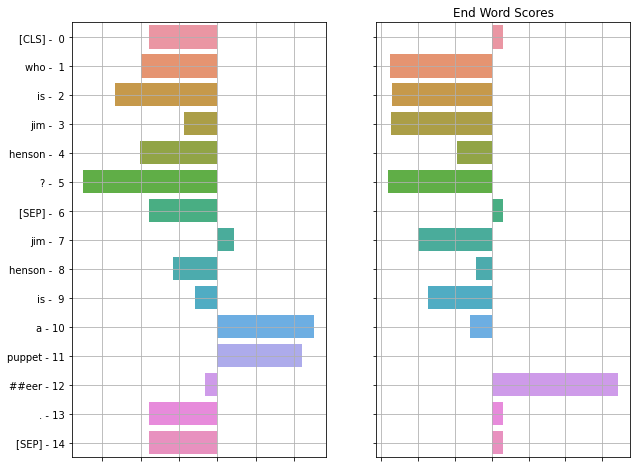

In [21]:
q_and_a('Who is Jim Henson?', 'Jim Henson is a puppeteer.', condense_subwords=True, display_scores=True)

# Wikipedia
* Nice library that wraps up access to wikipedia
  * Summary
  * Search
  * Page
  * Suggestion
* Given its use in many training datasets the library can be helpful!
* We'll use the API to form some questions

In [8]:
wikipedia.summary("CNN")

'Cable News Network (CNN) is an American news-based pay television channel owned by CNN Worldwide, a unit of the WarnerMedia News & Sports division of AT&T\'s WarnerMedia. CNN was founded in 1980 by American media proprietor Ted Turner and Reese Schonfeld as a 24-hour cable news channel. Upon its launch in 1980, CNN was the first television channel to provide 24-hour news coverage, and was the first all-news television channel in the United States.While the news channel has numerous affiliates, CNN primarily broadcasts from 30 Hudson Yards in New York City, and studios in Washington, D.C. and Los Angeles. Its headquarters at the CNN Center in Atlanta is only used for weekend programming. CNN is sometimes referred to as CNN/U.S. (or CNN Domestic) to distinguish the U.S. channel from its international sister network, CNN International.\nThe network is known for its dramatic live coverage of breaking news, some of which has drawn criticism as overly sensationalistic, and for its efforts t

In [9]:
wikipedia.search('Bill')

['Bill',
 'The Bill',
 'Bill Clinton',
 'Bill Gates',
 'NBA Finals Most Valuable Player Award',
 'Bill & Ted Face the Music',
 'Bills, Bills, Bills',
 'Bill Paxton',
 'Bill of Rights 1689',
 'Buffalo Bill']

In [10]:
wikipedia.suggest('Orygun')

'oregon'

In [11]:
page = wikipedia.page('London Heathrow Airport')
print('\n======= Title ========')
print(page.title)

print('\n======= URL ========')
print(page.url)

print('\n======= Categories ========')
print(page.categories)

print('\n======= Geo ========')
print(page.coordinates)


======= Title ========
Heathrow Airport

======= URL ========
https://en.wikipedia.org/wiki/Heathrow_Airport

======= Categories ========
['1929 establishments in England', 'Airports established in 1929', 'Airports in the London region', 'All articles containing potentially dated statements', 'All articles to be merged', 'All articles with unsourced statements', 'Articles containing potentially dated statements from 2013', 'Articles to be merged from May 2020', 'Articles with short description', 'Articles with unsourced statements from December 2019', 'Buildings and structures in the London Borough of Hillingdon', 'CS1 Dutch-language sources (nl)', 'CS1 errors: missing periodical', 'CS1 maint: archived copy as title', 'Commons category link is on Wikidata', 'Coordinates on Wikidata', 'EngvarB from July 2015', 'Heathrow Airport', 'Heathrow Airport Holdings', 'Pages containing links to subscription-only content', 'Proposed transport infrastructure in London', 'Public inquiries in the Un

In [12]:
print('\n======= Content ========')
print(page.content)


======= Content ========
Heathrow Airport, originally called London Airport (until 1966) and now known as London Heathrow (IATA: LHR, ICAO: EGLL), is a major international airport in London, England, United Kingdom. Heathrow is the second busiest airport in the world by international passenger traffic, as well as the busiest airport in Europe by passenger traffic, and the seventh busiest airport in the world by total passenger traffic. It is one of six international airports serving the London region. In 2019, it handled a record 80.8 million passengers, a 0.9% increase from 2018 as well as 475,861 aircraft movements, a decrease of 1,743 from 2018. The airport facility is owned and operated by Heathrow Airport Holdings.
Heathrow lies 14 miles (23 km) west of Central London, and has two parallel east–west runways along with four operational terminals on a site that covers 12.27 square kilometres (4.74 sq mi). The airport is the primary hub for British Airways and the primary operating 

In [13]:
print('\n======= Section ========')
print(page.section('Facilities'))


======= Section ========
Heathrow Airport is used by over 80 airlines flying to 185 destinations in 84 countries. The airport is the primary hub of British Airways and is a base for Virgin Atlantic. It has four passenger terminals (numbered 2 to 5) and a cargo terminal. Of Heathrow's 78 million passengers in 2017, 94% were international travellers; the remaining 6% were bound for (or arriving from) places in the UK. The busiest single destination in passenger numbers is New York, with over 3 million passengers flying between Heathrow and JFK Airport in 2013.In the 1950s, Heathrow had six runways, arranged in three pairs at different angles in the shape of a hexagram with the permanent passenger terminal in the middle and the older terminal along the north edge of the field; two of its runways would always be within 30° of the wind direction. As the required length for runways has grown, Heathrow now has only two parallel runways running east–west. These are extended versions of the tw

In [14]:
wikipedia.set_lang("fr")
wikipedia.summary("Google", sentences=1)
wikipedia.set_lang("en")

## Examples

In [15]:
q_and_a("What does the C in CNN stand for?", wikipedia.summary('CNN'))

Answer: "cable news network"


In [16]:
q_and_a('When were the Steelers created?', wikipedia.summary('Pittsburgh Steelers'))

Answer: "1933"


In [17]:
q_and_a('What is in pudding?', wikipedia.summary('Pudding'))

Answer: "a type of food that can be either a dessert or a sa ##vor ##y ( salty or spicy ) dish that is part of the main meal"


In [19]:
q_and_a('What position does Tom Brady play?', wikipedia.summary('TomBrady'))

Answer: "quarterback"


In [20]:
q_and_a('Who was the first president?', wikipedia.summary('List of presidents of the United States'))

Answer: "1789"


## Random Forest Example

In [33]:
print(wikipedia.summary('Random Forest'))

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set. Random forests generally outperform decision trees, but their accuracy is lower than gradient boosted trees. However, data characteristics can affect their performance.The first algorithm for random decision forests was created by Tin Kam Ho using the random subspace method, which, in Ho's formulation, is a way to implement the "stochastic discrimination" approach to classification proposed by Eugene Kleinberg.An extension of the algorithm was developed by Leo Breiman and Adele Cutler, who registered "Random Forests" as a trademark (as of 2019, owned by Minitab, Inc.). 

In [34]:
q_and_a('What is a random forest?', wikipedia.summary('Random Forest'))

Answer: ""


Answer: ""


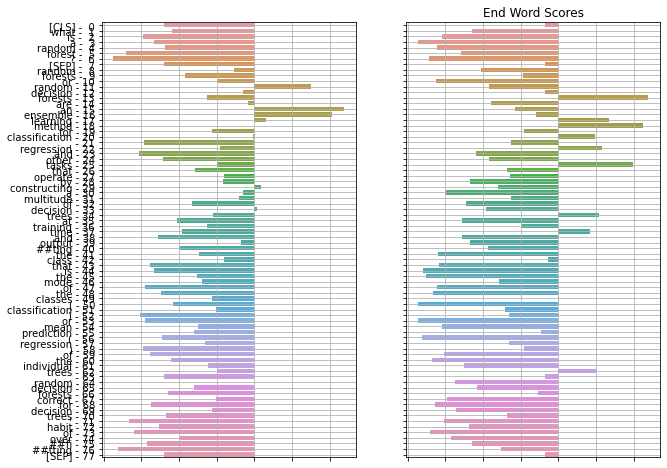

In [35]:
q_and_a('What is a random forest?', wikipedia.summary('Random Forest'), display_scores=True)

Answer: "an ensemble learning method"


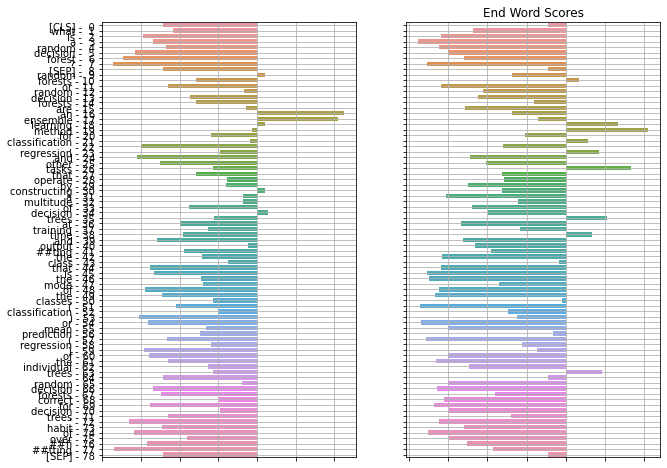

In [37]:
q_and_a('What is a random decision forest?', wikipedia.summary('Random Forest'), display_scores=True)

# SQuaD

![](https://miro.medium.com/max/1200/1*6ga054VrBMwLG4OC13bQoQ.png)

* Stanford Question and Answer Dataset
  * Imagenet of Q&A
  * Human Level Performance EM 86.831, F1 89.452
  * Top Model EM 90.724 F1 93.011
* Scoring 
  * EM = Exact Match of one of the provided answers
  * F1 = Token level match (partial credit)
* SQuaD 1.1 = 100,000 Questions, Text Context and Answers
* SQuaD 2.0 = 150,000 Questions, Text Context and Answers
  * 50,000 Adverserial Examples (Engineered to look real)
  * Must output nothing to get correct
* Site hosts a running competition (taking your model, scoring dev & test)
* https://rajpurkar.github.io/SQuAD-explorer/

In [22]:
answer_text = """The word pharmacy is derived from its root word pharma which was a term used 
since the 15th–17th centuries. However, the original Greek roots from pharmakos imply 
sorcery or even poison. In addition to pharma responsibilities, the pharma offered general 
medical advice and a range of services that are now performed solely by other specialist 
practitioners, such as surgery and midwifery. The pharma (as it was referred to) often 
operated through a retail shop which, in addition to ingredients for medicines, sold 
tobacco and patent medicines. Often the place that did this was called an apothecary 
and several languages have this as the dominant term, though their practices are more 
akin to a modern pharmacy, in English the term apothecary would today be seen as outdated 
or only approproriate if herbal remedies were on offer to a large extent. The pharmas also 
used many other herbs not listed. The Greek word Pharmakeia (Greek: φαρμακεία) derives from 
pharmakon (φάρμακον), meaning "drug", "medicine" (or "poison").[n 1]"""

In [23]:
question = "What goods were sold in a pharma?"
q_and_a(question, answer_text, condense_subwords=True)

Answer: "general medical advice and a range of services that are now performed solely by other specialist practitioners , such as surgery and midwifery"


In [24]:
question = "What word is the word pharmacy taken from?"
q_and_a(question, answer_text, condense_subwords=True)

Answer: "pharma"


# Training Set

## Download

In [25]:
!wget -O squad.json https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json

--2020-10-08 12:07:30--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘squad.json’

squad.json          100%[===================>]  28.88M  47.1MB/s    in 0.6s    

2020-10-08 12:07:31 (47.1 MB/s) - ‘squad.json’ saved [30288272/30288272]



## Parse

In [27]:
with open('squad.json', 'r') as f:
  j = json.load(f)

cases = []
for entry in j['data']:
    title = entry['title']
    for paragraph in entry['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            case = {}
            case['title'] = title
            case['context_text'] = context

            case['qas_id'] = qa['id']
            case['question_text'] = qa['question']
            
            answer = qa['answers'][0]
            case['answer_text'] = answer['text']
            case['start_position_character'] = answer['answer_start']                
            
            cases.append(case)
print(f'Loaded {len(cases):,} cases')

Loaded 87,599 cases


## Display

In [30]:
wrapper = textwrap.TextWrapper(width=80) 
case = cases[100]

print('Title:', case['title'])
print('ID:', case['qas_id'])

print('\n======== Question =========')
print(case['question_text'])

print('\n======== Context =========')
print(wrapper.fill(case['context_text']))

print('\n======== Answer =========')
print(case['answer_text'])

print('\n======== Position =========')
print(case['start_position_character'])


Title: University_of_Notre_Dame
ID: 573387acd058e614000b5cb5

======== Question =========
In what year did the team lead by Knute Rockne win the Rose Bowl?

======== Context =========
One of the main driving forces in the growth of the University was its football
team, the Notre Dame Fighting Irish. Knute Rockne became head coach in 1918.
Under Rockne, the Irish would post a record of 105 wins, 12 losses, and five
ties. During his 13 years the Irish won three national championships, had five
undefeated seasons, won the Rose Bowl in 1925, and produced players such as
George Gipp and the "Four Horsemen". Knute Rockne has the highest winning
percentage (.881) in NCAA Division I/FBS football history. Rockne's offenses
employed the Notre Dame Box and his defenses ran a 7–2–2 scheme. The last game
Rockne coached was on December 14, 1930 when he led a group of Notre Dame all-
stars against the New York Giants in New York City.

======== Answer =========
1925

======== Position =========
354


## Predict

In [31]:
q_and_a(case['question_text'], case['context_text'], condense_subwords=True)

Answer: "1925"
